In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

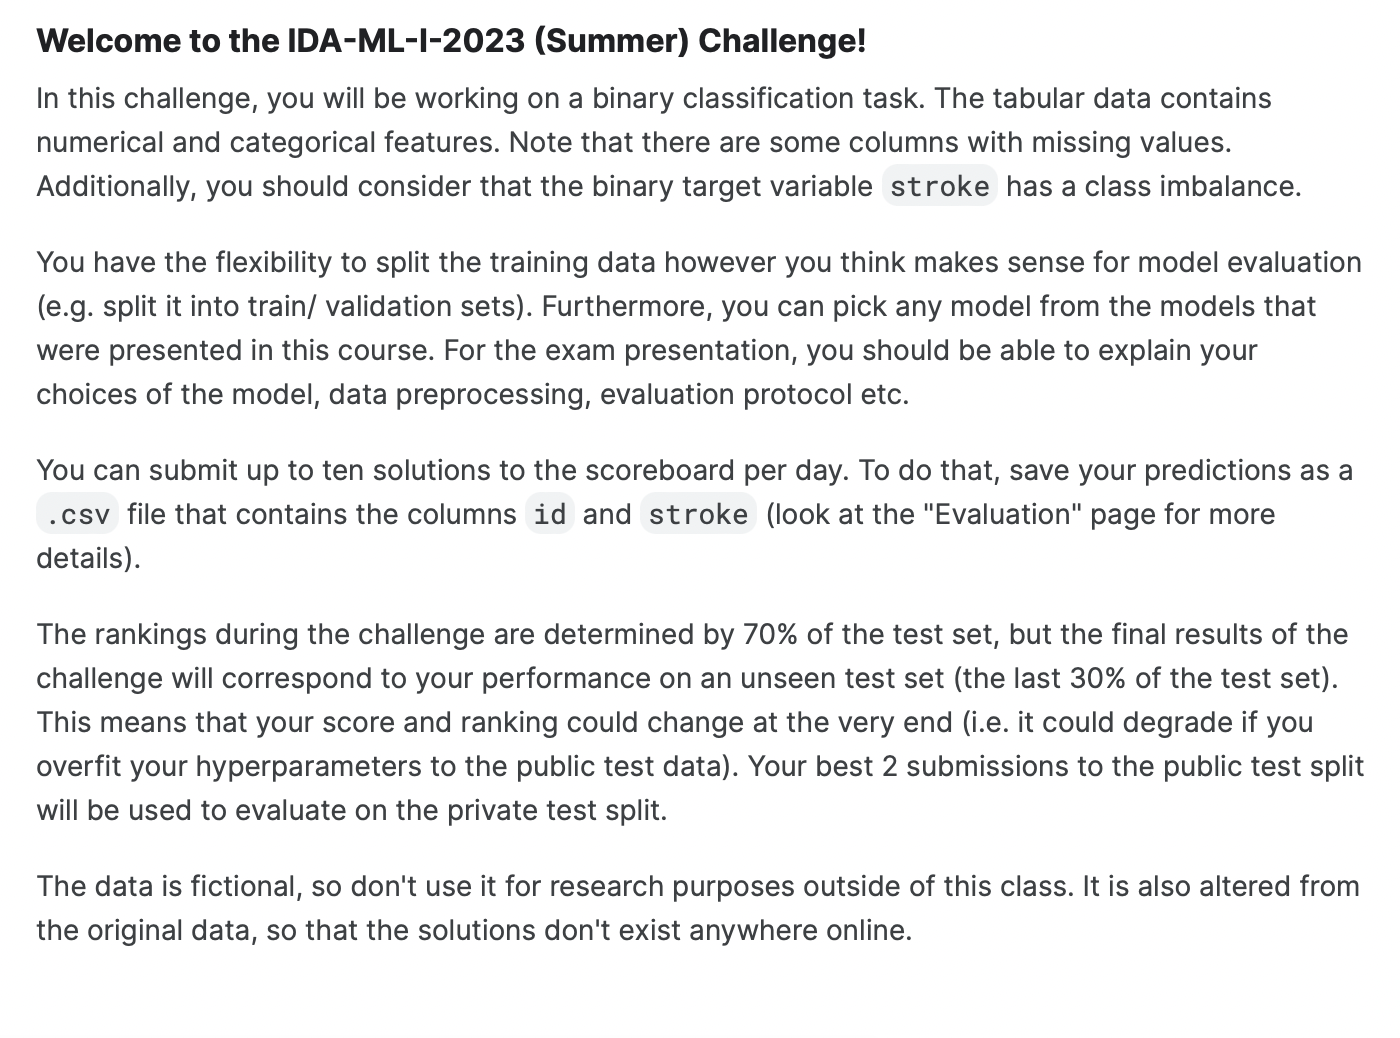

# Thought/ Project Process 
1. Looking at the data
    - try to understand what the data is about
    - looking at different statistics and any huge anomalies
    - looking at the unbalanced data
2. Handling Missing values/ data
    - look which data is missing 
    - do one hot encoding
    - think about different methods to try out 
        - Linear Regression/ take mean or median because of numerical values
        - decided for linear regression because computitional effort is small
3. Model engineering
    - Which model can i use? Are they better ones than others?
    - Run a bunch of different models and look which one has the highest AUC-Score (and take than this one)   
4. Train the Model and get optimal parameter
    - Took Decission Tree Classifier as Model and now looking for the optimal parameters
    - Did train/test split on the 'train' set -> *maybe not necessary?*
        - Train the model on them 
    - Train model on whole test set    
5. Applying model on 'test' set
    - Do the same methods as in 2 (one-hot encoding, linear regression to handle the missing data)
    - apply model on test
    - calculate the probabilities
    - Submit the result

In [2]:
train = pd.read_csv('ida-ml-1-challenge-summer23/train.csv')
test = pd.read_csv('ida-ml-1-challenge-summer23/test.csv')
samples = pd.read_csv('ida-ml-1-challenge-summer23/sample_submission.csv')

In [3]:
train.head(3)

,id,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Female,36,0,0,Private,Urban,93.962305,33.72,never smoked,0
1,1,Female,79,0,0,Private,Urban,NaN,31.32,never smoked,1
2,2,Male,68,0,0,Private,Urban,99.642305,30.60,formerly smoked,0


In [4]:
test.head(3)

,id,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,5000,Female,69,0,0,Private,Rural,103.052305,28.20,never smoked
1,5001,Male,67,0,0,Private,Urban,101.482305,55.08,never smoked
2,5002,Male,89,0,0,Govt_job,Rural,96.332305,NaN,Unknown


In [5]:
#train.isnull().sum()

In [6]:
#test.isnull().sum()

In [7]:
train[train['stroke'] == 0].shape[0]

4502

In [8]:
train[train['stroke'] == 1].shape[0]

498

In [9]:
def distribution_vis(column):
    sns.set(style="darkgrid")
    plt.figure(figsize=(5, 5))
    sns.countplot(data=train, x=column)
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

In [10]:
#distribution_vis('gender')

In [11]:
#distribution_vis('hypertension')

In [12]:
#distribution_vis('heart_disease')

In [13]:
#distribution_vis('work_type')

In [14]:
#distribution_vis('Residence_type')

In [15]:
#distribution_vis('smoking_status')

In [16]:
#distribution_vis('stroke')

In [17]:
def hist_vis(column):
    plt.figure(figsize=(5, 5))
    plt.hist(train[column], bins=20, edgecolor='k')
    plt.title('Distribution of Column')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.show()

In [18]:
#hist_vis('bmi')

In [19]:
#hist_vis('age')

In [20]:
#plt.figure(figsize=(6, 6))
#correlation_matrix = train.corr()
#sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
#plt.title('Correlation Matrix - Train')
#plt.show()

***
### Handling Missing Values: 

For me 3 possible ways to handle them: 
- fillnan with the mean
    - pros: easy to implement, do not change the mean overall
    - negatives: do not go with the distribution of the data frame
- fillnan with the median
    - pros: easy to implement, do not change the mean overall
    - negatives: do not go with the distribution of the data frame
- fillnan with a regression 
    - öiu

In [21]:
train['bmi'].mean()

33.890777262180976

In [22]:
train['avg_glucose_level'].mean()

91.48462802263728

In [23]:
#train_reg['avg_glucose_level'].mean()

In [24]:
#train_reg['bmi'].mean()

In [25]:
#train_reg['bmi'].mean()

In [26]:
#train_reg['avg_glucose_level'].mean()

In [27]:
#insert train/test split for the linear regression to have a better evaluation 

In [28]:
# Create a copy of the original 'train' DataFrame
train_reg = train.copy()

# Split the data into two parts: one with missing values and one without
train_missing = train_reg[train_reg['avg_glucose_level'].isnull() | train_reg['bmi'].isnull()]
train_nonmissing = train_reg.dropna(subset=['avg_glucose_level', 'bmi'])

# Encode the categorical features as one-hot encoded variables
categorical_features = ['gender', 'work_type', 'Residence_type']
train_nonmissing = pd.get_dummies(train_nonmissing, columns=categorical_features, drop_first=True)
train_missing = pd.get_dummies(train_missing, columns=categorical_features, drop_first=True)

# Define the target features and predictors
target_features = ['avg_glucose_level', 'bmi']
predictors = ['age', 'hypertension', 'heart_disease', 'gender_Male', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban']  # Use relevant predictors

# Train the regression model for each target feature
reg_models = {}
for feature in target_features:
    reg_model = LinearRegression()
    reg_model.fit(train_nonmissing[predictors], train_nonmissing[feature])
    reg_models[feature] = reg_model

# Predict the missing values using the regression models
imputed_values = pd.DataFrame(index=train_missing.index, columns=target_features)
for feature in target_features:
    imputed_values[feature] = reg_models[feature].predict(train_missing[predictors])

# Replace the missing values in the features with the predicted values
for feature in target_features:
    train_reg.loc[train_reg[feature].isnull(), feature] = imputed_values[feature]

In [29]:
# Evaluate the model using RMSE
for feature in target_features:
    actual_values = train_reg.loc[train_reg[feature].notnull(), feature]
    predicted_values = train_reg.loc[train_reg[feature].notnull(), feature]
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
    print(f"RMSE for {feature}: {rmse}")

    ''' 
# Perform cross-validation
for feature in target_features:
    cv_scores = cross_val_score(reg_models[feature], train_nonmissing[predictors], train_nonmissing[feature], cv=5, scoring='neg_root_mean_squared_error')
    avg_rmse = -np.mean(cv_scores)
    print(f"Cross-validated RMSE for {feature}: {avg_rmse}")
    '''

RMSE for avg_glucose_level: 0.0
RMSE for bmi: 0.0


### Test if there are no nan values

In [30]:
train_reg.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [31]:
categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
train_reg_dropped = train_reg.drop(columns=categorical_features)

# Perform one-hot encoding on the categorical features
train_encoded = pd.get_dummies(train_reg[categorical_features], drop_first=True)

# Concatenate the encoded columns back to the original DataFrame
train_reg_new = pd.concat([train_reg_dropped, train_encoded], axis=1)

columns = train_reg_new.columns.tolist()
columns.remove('stroke')
columns.append('stroke')
train_reg_new = train_reg_new[columns]

train_reg_new.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0,36,0,0,93.962305,33.72,0,0,1,0,0,1,0,1,0,0
1,1,79,0,0,91.143664,31.32,0,0,1,0,0,1,0,1,0,1
2,2,68,0,0,99.642305,30.60,1,0,1,0,0,1,1,0,0,0
3,3,34,0,0,75.752305,29.76,1,0,1,0,0,0,0,0,0,0
4,4,88,0,0,92.352305,34.44,1,0,0,1,0,0,0,1,0,0


***
## Model Engineering
### Try out per default values several models for the classification of strokes

In [32]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Define the models to evaluate
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    Perceptron(),
    LogisticRegression(),
    SVC()
]

In [33]:
X = train_reg_new.iloc[:, :-1]
y = train_reg_new['stroke']

# Split the data into train and test sets, considering the class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
X

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0,36,0,0,93.962305,33.720000,0,0,1,0,0,1,0,1,0
1,1,79,0,0,91.143664,31.320000,0,0,1,0,0,1,0,1,0
2,2,68,0,0,99.642305,30.600000,1,0,1,0,0,1,1,0,0
3,3,34,0,0,75.752305,29.760000,1,0,1,0,0,0,0,0,0
4,4,88,0,0,92.352305,34.440000,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4995,73,0,0,66.712305,35.237224,0,0,1,0,0,0,0,1,0
4996,4996,100,0,0,200.892305,54.600000,0,0,1,0,0,0,0,1,0
4997,4997,96,0,0,72.712305,37.800000,0,0,0,1,0,1,0,1,0
4998,4998,16,0,0,60.892305,24.400689,1,0,0,0,1,1,0,0,0


In [35]:
# Define a dictionary to store the evaluation metrics for each model
evaluation_metrics = {}

# Fit and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    
    evaluation_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}

/Users/linuszarse/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/linuszarse/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
# Print the evaluation metrics for each model
for model_name, metrics in evaluation_metrics.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

# Select the best model based on a chosen evaluation metric
best_model = max(evaluation_metrics, key=lambda x: evaluation_metrics[x]['F1-Score'])
print(f"The best model is: {best_model}")

Model: DecisionTreeClassifier
Accuracy: 0.846
Precision: 0.2672413793103448
Recall: 0.31
F1-Score: 0.287037037037037

Model: RandomForestClassifier
Accuracy: 0.89
Precision: 0.375
Recall: 0.15
F1-Score: 0.21428571428571425

Model: Perceptron
Accuracy: 0.839
Precision: 0.18556701030927836
Recall: 0.18
F1-Score: 0.18274111675126903

Model: LogisticRegression
Accuracy: 0.898
Precision: 0.47058823529411764
Recall: 0.16
F1-Score: 0.23880597014925375

Model: SVC
Accuracy: 0.9
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

The best model is: DecisionTreeClassifier


In [37]:
from sklearn.metrics import roc_auc_score

# Define the models to evaluate
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    Perceptron(),
    LogisticRegression(),
    SVC(probability=True)  # Setting probability=True to enable predict_proba for AUC score
]

# Define a dictionary to store the evaluation metrics for each model
evaluation_metrics = {}

# Fit and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for AUC score
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)  # Compute AUC score
    
    evaluation_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc}

# Print the evaluation metrics for each model
for model_name, metrics in evaluation_metrics.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

# Select the best model based on the AUC score
best_model = max(evaluation_metrics, key=lambda x: evaluation_metrics[x]['AUC'])
print(f"The best model is: {best_model}")


AttributeError: 'Perceptron' object has no attribute 'predict_proba'

In [ ]:
from sklearn.metrics import roc_auc_score

# Define the models to evaluate
models = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    Perceptron(),
    LogisticRegression(),
    SVC(probability=True)  # Setting probability=True to enable predict_proba for AUC score
]

# Define a dictionary to store the evaluation metrics for each model
evaluation_metrics = {}

# Fit and evaluate each model
for model in models:
    model_name = model.__class__.__name__
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for AUC score
        auc = roc_auc_score(y_test, y_pred_proba)  # Compute AUC score
    else:
        auc = None
    
    evaluation_metrics[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc}

# Print the evaluation metrics for each model
for model_name, metrics in evaluation_metrics.items():
    print(f"Model: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value}")
    print()

# Select the best model based on the AUC score (if available) or the F1 score
best_model = max(evaluation_metrics, key=lambda x: evaluation_metrics[x]['AUC'] if evaluation_metrics[x]['AUC'] is not None else evaluation_metrics[x]['F1-Score'])
print(f"The best model is: {best_model}")


## Okay because of this decission we will take the DecisionTreeClassifier as our model to go for the project :)

## Train the model 

### Find the best hyperparameters on the entire training data

In [ ]:
from tqdm import tqdm

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3],
    'class_weight': [None, 'balanced'],
    'splitter': ['best', 'random'],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2, 0.3],
    'ccp_alpha': [0.0, 0.1, 0.2, 0.3],
    'max_leaf_nodes': [None, 5, 10, 20],
    'random_state': [42],
}

model = DecisionTreeClassifier()

# Define the scoring metrics (F1 score and AUC score)
scoring = {'F1 Score': make_scorer(f1_score), 'AUC': make_scorer(roc_auc_score)}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, refit='F1 Score')
#grid_search.fit(X, y)

with tqdm(total=len(param_grid), desc="Grid Search Progress") as pbar:
    grid_search.fit(X, y) #model.fit(X_train, y_train)
    pbar.update(1)

In [ ]:
# Print the best parameter combination and corresponding F1 score and AUC score
print("Best Parameter Combination:")
print(grid_search.best_params_)
print("Best F1 Score:")
print(grid_search.best_score_)
print("Best AUC Score:")
print(grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_])

In [ ]:
# Set the optimal parameters
optimal_params = {
    'ccp_alpha': 0.0,
    'class_weight': 'balanced',
    'criterion': 'gini',
    'max_depth': None,
    'max_features': None,
    'max_leaf_nodes': 5,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.1,
    'random_state': 42,
    'splitter': 'random'
}

# Create the DecisionTreeClassifier model with optimal parameters
model = DecisionTreeClassifier(**optimal_params)

# Train the model o
model.fit(X, y)

In [ ]:
# Make predictions on the training set
y_pred = model.predict(X)

# Calculate the F1 score
f1 = f1_score(y, y_pred)

# Calculate the AUC score
y_pred_proba = model.predict_proba(X)[:, 1]
auc = roc_auc_score(y, y_pred_proba)

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)

# Print the evaluation metrics
print("F1 Score:", f1)
print("AUC Score:", auc)
print("Accuracy:", accuracy)

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))

plot_tree(
    model, 
    filled=True, 
    rounded=True, 
    fontsize=14);

***
## Applying Model on Test

In [ ]:
test.head(3)

In [ ]:
# Create a copy of the original 'train' DataFrame
test_reg = test.copy()

# Split the data into two parts: one with missing values and one without
test_missing = test_reg[test_reg['avg_glucose_level'].isnull() | test_reg['bmi'].isnull()]
test_nonmissing = test_reg.dropna(subset=['avg_glucose_level', 'bmi'])

# Encode the categorical features as one-hot encoded variables
categorical_features = ['gender', 'work_type', 'Residence_type']
test_nonmissing = pd.get_dummies(test_nonmissing, columns=categorical_features, drop_first=True)
test_missing = pd.get_dummies(test_missing, columns=categorical_features, drop_first=True)

In [ ]:
# Define the target features and predictors
target_features = ['avg_glucose_level', 'bmi']
predictors = ['age', 'hypertension', 'heart_disease', 'gender_Male', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban']  # Use relevant predictors

# Test the regression model for each target feature
reg_models = {}
for feature in target_features:
    reg_model = LinearRegression()
    reg_model.fit(test_nonmissing[predictors], test_nonmissing[feature])
    reg_models[feature] = reg_model

# Predict the missing values using the regression models
imputed_values = pd.DataFrame(index=test_missing.index, columns=target_features)
for feature in target_features:
    imputed_values[feature] = reg_models[feature].predict(test_missing[predictors])

# Replace the missing values in the features with the predicted values
for feature in target_features:
    test_reg.loc[test_reg[feature].isnull(), feature] = imputed_values[feature]

In [ ]:
test_reg.head(3)

In [ ]:
categorical_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
test_reg_dropped = test_reg.drop(columns=categorical_features)

# Perform one-hot encoding on the categorical features
test_encoded = pd.get_dummies(test_reg[categorical_features], drop_first=True)

# Concatenate the encoded columns back to the original DataFrame
test_reg_new = pd.concat([test_reg_dropped, test_encoded], axis=1)
test_reg_new.head()

In [ ]:
test_reg['bmi'].mean()

In [ ]:
test_reg['avg_glucose_level'].mean()

In [ ]:
X_test = test_reg_new
X_test.head(3)

In [ ]:
y_pred = model.predict(X_test)

# Get the predicted probabilities for stroke
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class (stroke)

# Create a DataFrame with id and stroke probabilities
y_test_pred = pd.DataFrame({
    "id": np.arange(5_000, 6_000),
    "stroke": y_pred_proba
})

# Save the predictions to a CSV file
y_test_pred.to_csv("y_test_pred.csv", index=False)


In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25,10))

plot_tree(
    model, 
    filled=True, 
    rounded=True, 
    fontsize=14);

***
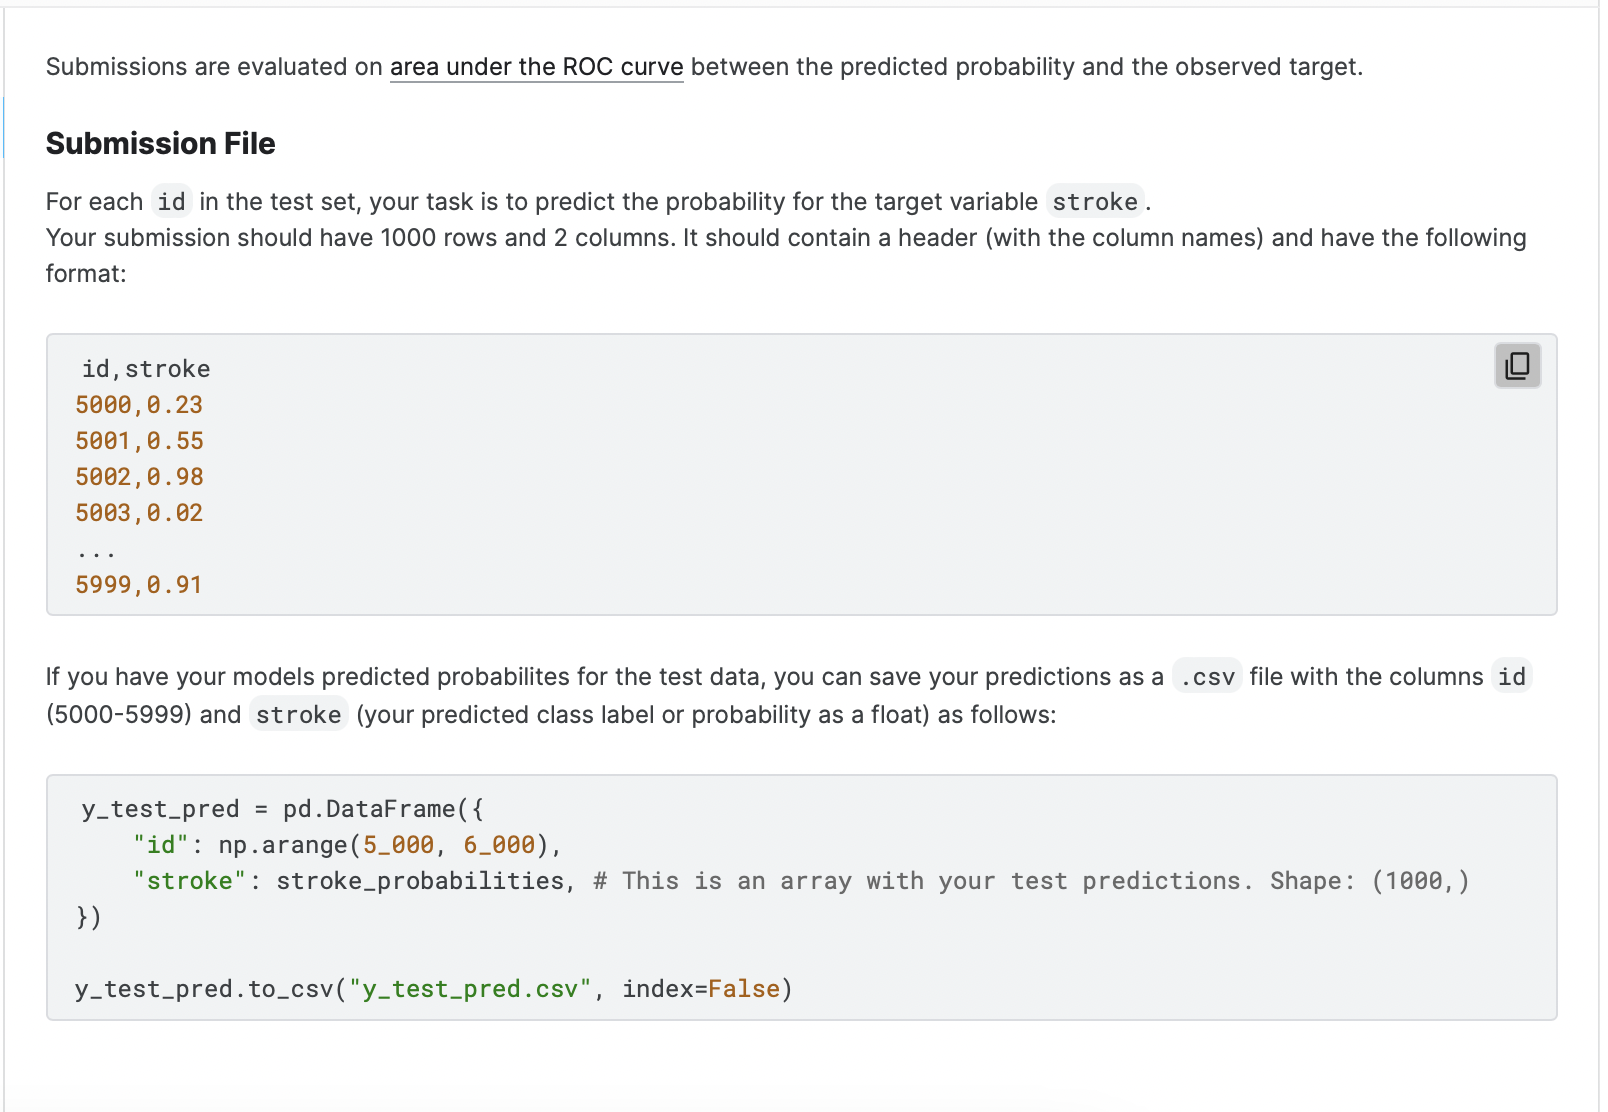

In [ ]:
from tqdm import tqdm
from sklearn.svm import SVC

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type (linear, radial basis function)
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Create the SVM model
model = SVC(probability=True)  # Setting probability=True to enable predict_proba for AUC score

# Define the scoring metric (AUC score)
scoring = make_scorer(roc_auc_score)

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X, y)

# Print the best parameter combination and corresponding AUC score
print("Best Parameter Combination:")
print(grid_search.best_params_)
print("Best AUC Score:")
print(grid_search.best_score_)


In [ ]:
# Print the best parameter combination and corresponding F1 score and AUC score
print("Best Parameter Combination:")
print(grid_search.best_params_)
print("Best F1 Score:")
print(grid_search.best_score_)
print("Best AUC Score:")
print(grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_])

In [ ]:
# Create the DecisionTreeClassifier model with optimal parameters
model_svm = SVC(probability=True,**optimal_params)

# Train the model o
model.fit(X, y)

*** 
## Overfitted Model 

In [ ]:
from sklearn.ensemble import BaggingClassifier

# Create the BaggingClassifier model
bagging_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)

# Fit the BaggingClassifier model on the data
bagging_model.fit(X, y)

# Make predictions with the BaggingClassifier model
bagging_predictions = bagging_model.predict(X)
bagging_f1_score = f1_score(y, bagging_predictions)


# Print the F1 scores
print("F1 Score:", bagging_f1_score)

In [ ]:
from sklearn.metrics import roc_auc_score

# Make predictions on probabilities with the BaggingClassifier model
bagging_probabilities = bagging_model.predict_proba(X)
bagging_auc_score = roc_auc_score(y, bagging_probabilities[:, 1])

# Print the AUC scores
print("BaggingClassifier AUC Score:", bagging_auc_score)
#print("AdaBoostClassifier AUC Score:", adaboost_auc_score)


In [ ]:
y_pred = bagging_model.predict(X_test)

# Get the predicted probabilities for stroke
y_pred_proba = bagging_model.predict_proba(X_test)[:, 1]  # Probabilities of the positive class (stroke)

# Create a DataFrame with id and stroke probabilities
y_test_pred = pd.DataFrame({
    "id": np.arange(5_000, 6_000),
    "stroke": y_pred_proba
})

# Save the predictions to a CSV file
y_test_pred.to_csv("y_test_pred_bagging.csv", index=False)


***
## Backup

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Create the DecisionTreeClassifier model
#model = DecisionTreeClassifier(class_weight='balanced')
model = DecisionTreeClassifier()
#model = RandomForestClassifier()

# Define the scoring metric (F1 score)
scoring = make_scorer(f1_score)

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)
grid_search.fit(X, y)

# Print the best parameter combination and corresponding F1 score
print("Best Parameter Combination:")
print(grid_search.best_params_)
print("Best F1 Score:")
print(grid_search.best_score_)

In [ ]:
# Create a copy of the original 'train' DataFrame
train_reg = train.copy()

# Split the data into two parts: one with missing values and one without
train_missing = train_reg[train_reg['avg_glucose_level'].isnull() | train_reg['bmi'].isnull()]
train_nonmissing = train_reg.dropna(subset=['avg_glucose_level', 'bmi'])

# Encode the categorical features as one-hot encoded variables
categorical_features = ['gender', 'work_type', 'Residence_type']
train_nonmissing = pd.get_dummies(train_nonmissing, columns=categorical_features, drop_first=True)
train_missing = pd.get_dummies(train_missing, columns=categorical_features, drop_first=True)

# Define the target features and predictors
target_features = ['avg_glucose_level', 'bmi']
predictors = ['age', 'hypertension', 'heart_disease', 'gender_Male', 'work_type_Private', 'work_type_Self-employed', 'work_type_children', 'Residence_type_Urban']  # Use relevant predictors

# Train the regression model for each target feature
reg_models = {}
for feature in target_features:
    reg_model = LinearRegression()
    reg_model.fit(train_nonmissing[predictors], train_nonmissing[feature])
    reg_models[feature] = reg_model

# Predict the missing values using the regression models
imputed_values = pd.DataFrame(index=train_missing.index, columns=target_features)
for feature in target_features:
    imputed_values[feature] = reg_models[feature].predict(train_missing[predictors])

# Replace the missing values in the features with the predicted values
for feature in target_features:
    train_reg.loc[train_reg[feature].isnull(), feature] = imputed_values[feature]

In [ ]:

# Create a copy of train
train_reg = train.copy()

# Split the data into two parts: one with missing values and one without
train_missing = train_reg[train_reg['avg_glucose_level'].isnull() | train_reg['bmi'].isnull()]
train_nonmissing = train_reg.dropna(subset=['avg_glucose_level', 'bmi'])

# Define the target features and predictors
target_features = ['avg_glucose_level', 'bmi']
predictors = ['age', 'hypertension', 'heart_disease']  # Use relevant predictors

reg_models = {}
for feature in target_features:
    reg_model = LinearRegression()
    reg_model.fit(train_nonmissing[predictors], train_nonmissing[feature])
    reg_models[feature] = reg_model

imputed_values = pd.DataFrame(index=train_missing.index, columns=target_features)
for feature in target_features:
    imputed_values[feature] = reg_models[feature].predict(train_missing[predictors])

# Replace the missing values in the features with the predicted values
for feature in target_features:
    train_reg.loc[train_reg[feature].isnull(), feature] = imputed_values[feature]

train_reg.head()

In [ ]:
from tqdm import tqdm
from sklearn.svm import SVC

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type (linear, radial basis function)
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf' kernel
}

# Create the SVM model
model = SVC(probability=True)  # Setting probability=True to enable predict_proba for AUC score

# Define the scoring metrics (F1 score and AUC score)
scoring = {'F1 Score': make_scorer(f1_score), 'AUC': make_scorer(roc_auc_score)}

# Perform grid search
grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5, refit='F1 Score')

# Train the model using grid search
with tqdm(total=len(param_grid), desc="Grid Search Progress") as pbar:
    grid_search.fit(X, y)
    pbar.update(1)
